#library

In [1]:
import os
import glob
import random
import tensorflow
import numpy as np
from sklearn import svm
from keras import layers
from keras import models
from skimage import feature
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.python import image
from keras.utils import to_categorical
from keras.layers.core.dense import Dense
from sklearn.metrics import accuracy_score
from keras.utils.vis_utils import plot_model
from tensorflow.python.ops.math_ops import add
from keras.engine.sequential import Sequential
from sklearn.preprocessing import LabelEncoder
from keras.layers.serialization import activation
from tensorflow.python.ops.math_ops import Sigmoid
from sklearn.model_selection import train_test_split
from keras.layers.convolutional.base_separable_conv import activations
import cv2 as cv
from sklearn import svm

In [2]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from sklearn.metrics import accuracy_score
from skimage.color import label2rgb

In [3]:
def main(img):
  img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  img = cv.medianBlur(img,11)
  thresh = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
              cv.THRESH_BINARY,11,5)
  contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  return contours

#Part1.compatness

In [4]:
def compatness(image):
  _,_,area_indx,area,cnt = biggest_shape(image)
  perimeter = cv.arcLength(cnt[area_indx], True)
  compactness_score = (4*np.pi*area)/perimeter

  return compactness_score

#Part2.eccenticity

In [5]:
def eccenticity(image):
  indx,_,_,_,cnt_list = biggest_shape(image)
  (x,y),(MA,ma),angle = cv.fitEllipse(cnt_list[indx])
  try:
    eccentricity_score = ma/MA
  except:
    eccentricity_score = 0
  return eccentricity_score

#Part3.solidity

In [6]:
def biggest_shape(image):
  hull_area = []
  hull = []
  cnt_list = []
  cnt = main(image)
  area = cv.contourArea(cnt[0])
  for i in range(len(cnt)):
    if cnt[i].shape[0]>4:
      hold = cv.convexHull(cnt[i], False)
      hull_area.append(cv.contourArea(hold))
      hull.append(cv.contourArea(cnt[i]))
      cnt_list.append(cnt[i])

    

  return hull_area.index(max(hull_area)),max(hull_area),hull.index(max(hull)),max(hull),cnt_list

In [7]:
def solidity(image):
  _,hull,_,area,_=biggest_shape(image)
  solidity_score = round(float(area)/hull,2)
  return  solidity_score


#Part4.LBP

In [8]:
def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')

def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                  facecolor='0.5')

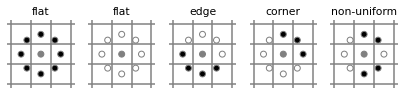

In [9]:


METHOD = 'uniform'
plt.rcParams['font.size'] = 9


def plot_circle(ax, center, radius, color):
    circle = plt.Circle(center, radius, facecolor=color, edgecolor='0.5')
    ax.add_patch(circle)


def plot_lbp_model(ax, binary_values):
    """Draw the schematic for a local binary pattern."""
    # Geometry spec
    theta = np.deg2rad(45)
    R = 1
    r = 0.15
    w = 1.5
    gray = '0.5'

    # Draw the central pixel.
    plot_circle(ax, (0, 0), radius=r, color=gray)
    # Draw the surrounding pixels.
    for i, facecolor in enumerate(binary_values):
        x = R * np.cos(i * theta)
        y = R * np.sin(i * theta)
        plot_circle(ax, (x, y), radius=r, color=str(facecolor))

    # Draw the pixel grid.
    for x in np.linspace(-w, w, 4):
        ax.axvline(x, color=gray)
        ax.axhline(x, color=gray)

    # Tweak the layout.
    ax.axis('image')
    ax.axis('off')
    size = w + 0.2
    ax.set_xlim(-size, size)
    ax.set_ylim(-size, size)


fig, axes = plt.subplots(ncols=5, figsize=(7, 2))

titles = ['flat', 'flat', 'edge', 'corner', 'non-uniform']

binary_patterns = [np.zeros(8),
                   np.ones(8),
                   np.hstack([np.ones(4), np.zeros(4)]),
                   np.hstack([np.zeros(3), np.ones(5)]),
                   [1, 0, 0, 1, 1, 1, 0, 0]]

for ax, values, name in zip(axes, binary_patterns, titles):
    plot_lbp_model(ax, values)
    ax.set_title(name)

In [10]:
def HIST_creator(data):
  radius = 3
  n_points = 8 * radius
  feature_matrix = []

  for image in data:
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(image, n_points, radius, METHOD)



    fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
    plt.gray()

    titles = ('edge', 'flat', 'corner')
    w = width = radius - 1
    edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
    flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
    i_14 = n_points // 4            # 1/4th of the histogram
    i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
    corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                    list(range(i_34 - w, i_34 + w + 1)))

    label_sets = (edge_labels, flat_labels, corner_labels)
    feature_matrix.append(label_sets)
    print(label_sets)

    for ax, labels in zip(ax_img, label_sets):
        ax.imshow(overlay_labels(image, lbp, labels))

    for ax, labels, name in zip(ax_hist, label_sets, titles):
        counts, _, bars = hist(ax, lbp)
        highlight_bars(bars, labels)
        ax.set_ylim(top=np.max(counts[:-1]))
        ax.set_xlim(right=n_points + 2)
        ax.set_title(name)

    ax_hist[0].set_ylabel('Percentage')
    for ax in ax_img:
        ax.axis('off')
  
  return feature_matrix


In [11]:
def kullback_leibler_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))



In [12]:
def histogram_of_LBP(image, numPoints, radius, eps=1e-7):

	n_points = numPoints * radius
	best_score = 10
	best_name = None

	image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

	lbp = local_binary_pattern(image, n_points, radius, METHOD)
	n_bins = int(lbp.max() + 1)
	hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
	hist_values = [hist,lbp]

	return hist_values	

#validate function

In [13]:
def validating_func(ship_img, airplane_img):
  eccenticity_ship, eccenticity_airplane = eccenticity(ship_img), eccenticity(airplane_img)
  compatness_ship, compatness_airplane = compatness(ship_img), compatness(airplane_img)
  solidity_ship, solidity_airplane = solidity(ship_img), solidity(airplane_img)
  print(f"Result for ship image:\ncompatness is : {compatness_ship}\t\teccenticity is : {eccenticity_ship}\t\tsolidity is : {solidity_ship}")
  print(f"Result for airplane image:\ncompatness is : {compatness_airplane}\t\teccenticity is : {eccenticity_airplane}\t\tsolidity is : {solidity_airplane}")
  

#Part5.prepare dataset(just run this cell and not change)

In [14]:
!gdown --id 1O_VkcGlWRR6h00VT8nXIgeI3RyvBpXbE
!unzip dataset.zip
classes = os.listdir("/content/dataset")
images_paths = glob.glob("/content/dataset/*/*")

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1O_VkcGlWRR6h00VT8nXIgeI3RyvBpXbE
To: /content/dataset.zip
100% 18.4M/18.4M [00:00<00:00, 120MB/s]
Archive:  dataset.zip
   creating: dataset/
   creating: dataset/airplane/
  inflating: dataset/airplane/airplane1.jpg  
  inflating: dataset/airplane/airplane136.jpg  
  inflating: dataset/airplane/airplane14.jpg  
  inflating: dataset/airplane/airplane141.jpg  
  inflating: dataset/airplane/airplane153.jpg  
  inflating: dataset/airplane/airplane156.jpg  
  inflating: dataset/airplane/airplane157.jpg  
  inflating: dataset/airplane/airplane159.jpg  
  inflating: dataset/airplane/airplane169.jpg  
  inflating: dataset/airplane/airplane170.jpg  
  inflating: dataset/airplane/airplane182.jpg  
  inflating: dataset/airplane/airp

In [15]:
x_data , y_data = [], []
for img_path in images_paths:
  x_data.append(cv.resize(cv.imread(img_path), (224,224)))
  if img_path.split("/")[3] == "ship":
    y_data.append(0)
  else:
    y_data.append(1)  

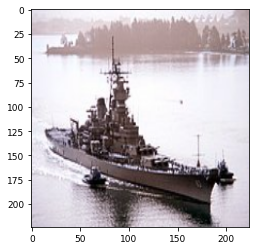

In [16]:
plt.imshow(x_data[0])

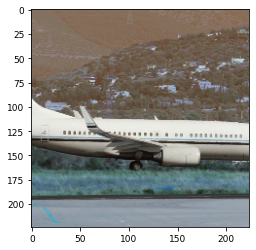

In [17]:
plt.imshow(x_data[180])

In [18]:
validating_func(x_data[0], x_data[180])

Result for ship image:
compatness is : 451.3656397943394		eccenticity is : 1.1479488772381354		solidity is : 0.98
Result for airplane image:
compatness is : 252.14750472095452		eccenticity is : 1.1823563615184038		solidity is : 0.92


In [19]:
 x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,test_size = 0.2, shuffle= True)

#Part6. Exctract features and determine classifier

In [27]:
def get_featureMatrix(data):
  feature = []
  for counter in range(len(data)):
    image = data[counter]
    hold = histogram_of_LBP(image, 8, 2)
    feature.append([eccenticity(image),compatness(image),solidity(image)]+hold[0].tolist())
  return feature


In [28]:
# model 1
feature_matrix_train = get_featureMatrix(x_train)
#determine classifier and train 

In [29]:
clf = svm.SVC()
clf.fit(feature_matrix_train, y_train)

SVC()

#Part7

In [30]:
#test on test dataset
y_pred  = []
for counter in range(len(x_test)):
  image = x_test[counter]
  hold = histogram_of_LBP(image, 8, 2)
  feature = [eccenticity(image),compatness(image),solidity(image)]+hold[0].tolist()
  y_pred.append(clf.predict([feature])[0])

print(accuracy_score(y_test,y_pred))


0.6875


#Part8

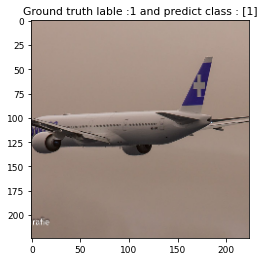

In [24]:
#test visualize
index = random.randint(0, len(x_test)-1)
prediction = clf.predict(get_featureMatrix(np.array([x_test[index]])))
plt.title(f"Ground truth lable :{y_test[index]} and predict class : {prediction}")
plt.imshow(x_test[index])
plt.show()